In [1]:
import cv2 as cv
import numpy as np
from skimage.feature import local_binary_pattern
from scipy.stats import mode
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.metrics import accuracy_score , confusion_matrix

In [2]:
image_train=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/image_train.npy")
label_train=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/label_train.npy")
image_test=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/image_test.npy")
label_test=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/label_test.npy")

In [11]:
def confusion_image(label_test, y_test_pred, cutoff=1):

    # Step 1: Compute the confusion matrix
    cm = confusion_matrix(label_test, y_test_pred)
    
    # Step 2: Normalize the confusion matrix to range [0, 255]
    cm_normalized = (cm / cm.max()) * 255
    cm_image = Image.fromarray(cm_normalized.astype('uint8'))
    
    # Step 3: Apply contrast stretching
    cm_image = ImageOps.autocontrast(cm_image, cutoff=cutoff)
    
    # Step 4: Plot the confusion matrix
    plt.imshow(cm_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Step 5: Calculate and return accuracy
    accuracy = (cm.diagonal().sum()) / cm.sum()
    print("Accuracy:", accuracy)

In [5]:
radius = 2
n_points = 8 * radius
method = 'uniform'

# Shuffle the training data and labels
indices = np.arange(len(image_train))
np.random.shuffle(indices)
image_train = image_train[indices]
label_train = label_train[indices]

# Shuffle the test data and labels
indices = np.arange(len(image_test))
np.random.shuffle(indices)
image_test = image_test[indices]
label_test = label_test[indices]


LBP_train = [
    local_binary_pattern(cv.cvtColor(img, cv.COLOR_RGB2GRAY), n_points, radius, method)
    for img in image_train
]
LBP_test = [
    local_binary_pattern(cv.cvtColor(img, cv.COLOR_RGB2GRAY), n_points, radius, method)
    for img in image_test
]

In [6]:
n_bins = n_points + 2
LBP_train_histogram = np.array([
    cv.calcHist([lbp.astype('float32')], [0], None, [n_bins], [0, n_bins]).flatten()
    for lbp in LBP_train
])
LBP_test_histogram = np.array([
    cv.calcHist([lbp.astype('float32')], [0], None, [n_bins], [0, n_bins]).flatten()
    for lbp in LBP_test
])

LBP_all=np.concatenate((LBP_train_histogram,LBP_test_histogram),axis=0)
mean = np.mean(LBP_all, axis=0)
std = np.std(LBP_all, axis=0)

LBP_train_histogram = (LBP_train_histogram - mean) / std
LBP_test_histogram = (LBP_test_histogram - mean) / std


label_train = label_train.flatten()
label_test = label_test.flatten()

In [7]:
def knn_predict(X_train, y_train, X_test, k=3):
    predictions = []
    for x_test in X_test:
        # Compute distances to all training points
        distances = np.linalg.norm(X_train - x_test, axis=1)

        # Find the k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]

        # Determine the most common label
        unique_labels, counts = np.unique(k_labels, return_counts=True)
        most_common = unique_labels[np.argmax(counts)]
        
        predictions.append(most_common)

    return np.array(predictions)

In [8]:
y_test_pred_KNN  = knn_predict(LBP_train_histogram, label_train, LBP_test_histogram, k=3)  # Use a subset of test data for speed

accuracy = np.mean(y_test_pred_KNN  == label_test)  # Match the subset size
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 61.99%


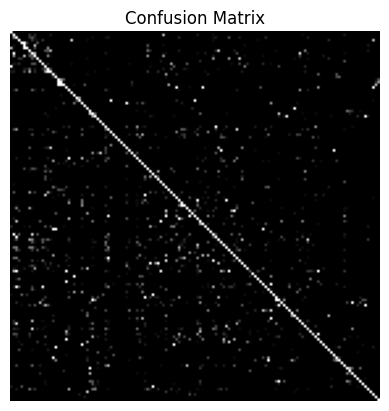

Accuracy: 0.6199246369448326


In [9]:
confusion_image(label_test, y_test_pred_KNN)

In [10]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(LBP_train_histogram, label_train)


y_test_pred_SVM = svm_model.predict(LBP_test_histogram)
print("Test Accuracy:", accuracy_score(label_test, y_test_pred_SVM))

Test Accuracy: 0.7019772217282696


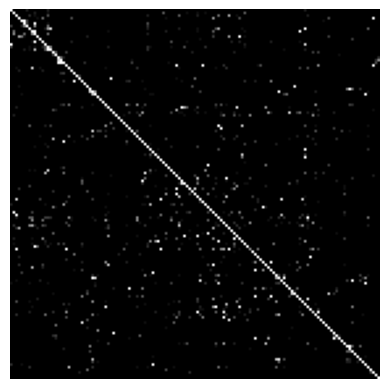

Accuracy: 0.7019772217282696


In [12]:
confusion_image(label_test, y_test_pred_SVM)

In [34]:
def k_means(data, k, max_iters=10000, tol=1e-6):
    
    n_samples, _ = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    
    for i in range(max_iters):
        distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        error=np.linalg.norm(new_centroids - centroids)

        if error < tol:
            print(error)
            break
        
        centroids = new_centroids

    return labels, centroids


def calculate_cluster_labels(labels_train, label_train, k):
    cluster_labels = np.empty(k, dtype=object)  # Use dtype=object for non-numeric labels

    for i in range(k):
        cluster_indices = np.where(labels_train == i)[0]
        true_labels = label_train[cluster_indices].flatten()

        if len(true_labels) > 0: 
            unique_labels, counts = np.unique(true_labels, return_counts=True)
            cluster_labels[i] = unique_labels[np.argmax(counts)]

    # Map each data point's cluster to its corresponding label
    predicted_labels = np.array([cluster_labels[label] for label in labels_train])

    # Calculate accuracy
    accuracy = np.mean(predicted_labels.flatten() == label_train.flatten())
    
    return cluster_labels, predicted_labels, accuracy


In [22]:
# Run K-Means clustering on the training histograms
k = 141  # Number of clusters
LBP_histogram=np.concatenate((LBP_train_histogram,LBP_test_histogram),axis=0)
label=np.concatenate((label_train,label_test),axis=0)
labels_train, centroids = k_means(LBP_histogram, k)

0.0


In [26]:
cluster_labels, predicted_labels, accuracy = calculate_cluster_labels(labels_train, label, k)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 42.51%


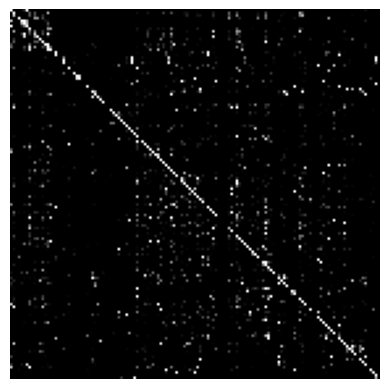

Accuracy: 0.4250982892360004


In [47]:
confusion_image(label, predicted_labels)

In [28]:
print(predicted_labels.shape)

(94110,)


True Label: Carambula 1
SVM Predicted Label: Cactus fruit 1
KNN Predicted Label: Cucumber Ripe 2
K_means Predicted Label: Nectarine Flat 1


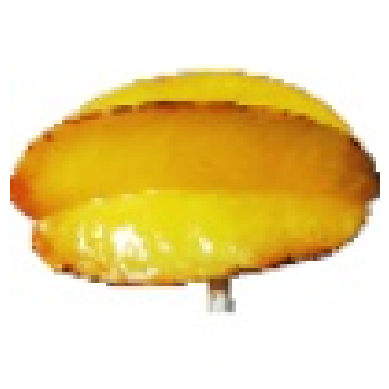

True Label: Nectarine Flat 1
SVM Predicted Label: Nectarine Flat 1
KNN Predicted Label: Nectarine Flat 1
K_means Predicted Label: Fig 1


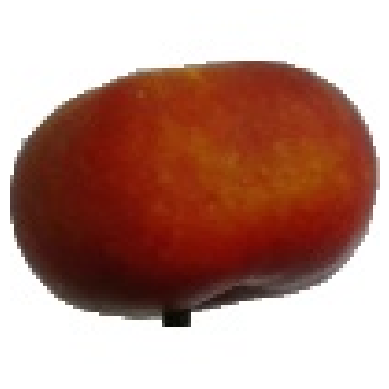

True Label: Limes 1
SVM Predicted Label: Limes 1
KNN Predicted Label: Guava 1
K_means Predicted Label: Guava 1


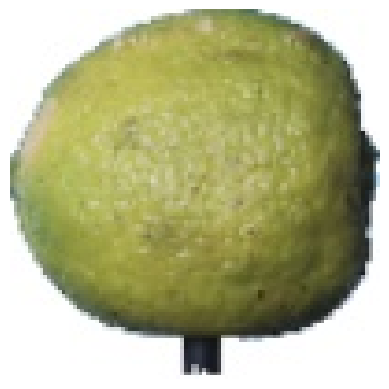

True Label: Potato Sweet 1
SVM Predicted Label: Potato Sweet 1
KNN Predicted Label: Beetroot 1
K_means Predicted Label: Potato Sweet 1


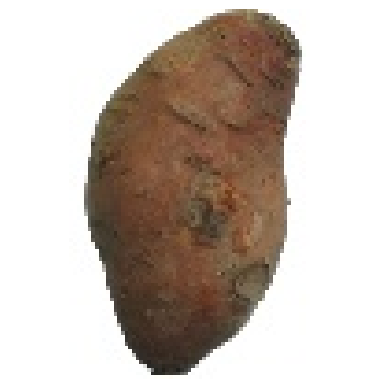

True Label: Cherry Wax Yellow 1
SVM Predicted Label: Cherry Wax Yellow 1
KNN Predicted Label: Cherry Wax Yellow 1
K_means Predicted Label: Cherry Wax Yellow 1


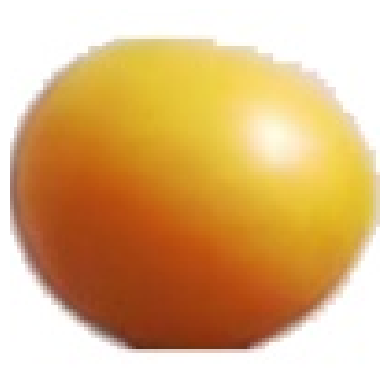

True Label: Tomato Cherry Red 1
SVM Predicted Label: Tomato Cherry Red 1
KNN Predicted Label: Tomato Cherry Red 1
K_means Predicted Label: Redcurrant 1


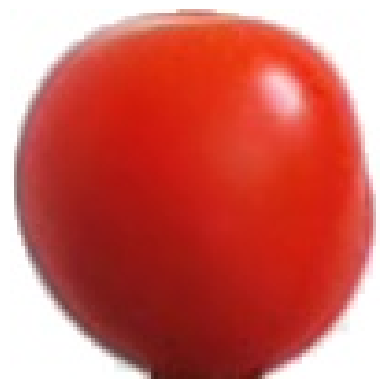

True Label: Tangelo 1
SVM Predicted Label: Pear Red 1
KNN Predicted Label: Tangelo 1
K_means Predicted Label: Tangelo 1


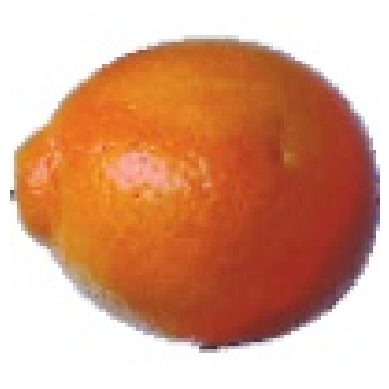

True Label: Onion Red Peeled 1
SVM Predicted Label: Tomato not Ripened 1
KNN Predicted Label: Apple Crimson Snow 1
K_means Predicted Label: Apple Pink Lady 1


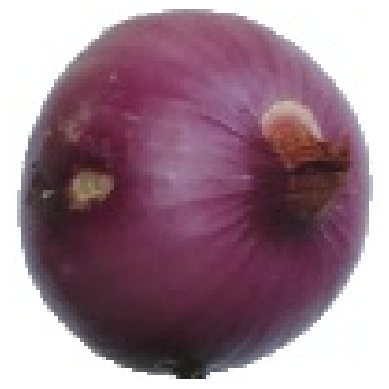

True Label: Dates 1
SVM Predicted Label: Dates 1
KNN Predicted Label: Dates 1
K_means Predicted Label: Dates 1


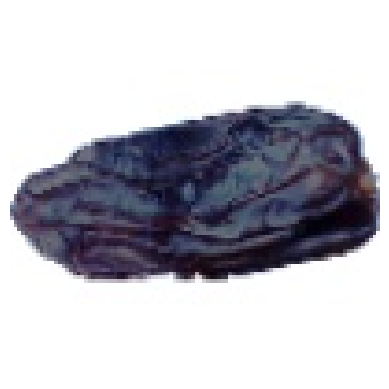

True Label: Walnut 1
SVM Predicted Label: Walnut 1
KNN Predicted Label: Walnut 1
K_means Predicted Label: Walnut 1


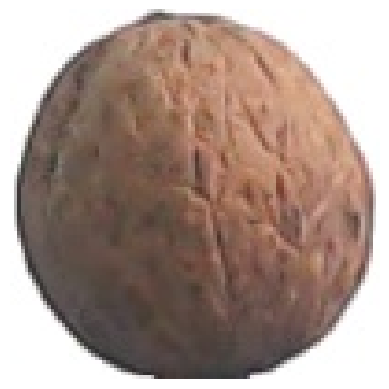

In [48]:
random_array = np.random.randint(0, 23619, size=10)
random_array

for i in range(len(random_array)):
    plt.imshow(image_test[random_array[i],:,:,::-1])
    print("True Label:", label_test[random_array[i]])
    print("SVM Predicted Label:", y_test_pred_SVM[random_array[i]])
    print("KNN Predicted Label:", y_test_pred_KNN[random_array[i]])
    print("K_means Predicted Label:", predicted_labels[random_array[i]+70491])
    plt.axis('off')
    plt.show()